In [1]:
%matplotlib inline

import json
import random
from collections import defaultdict
from pathlib import Path
from typing import Callable
from PIL import Image, ImageFilter

import torch
import torch.distributed as dist
import matplotlib.pyplot as plt
import matplotlib as mpl
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.distributed import DistributedSampler
from torchvision import transforms
from torchvision.transforms.functional import crop, resize

from IPython.core.debugger import set_trace

mpl.rcParams['figure.dpi']= 200

In [2]:
def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


class GaussianBlur:
    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, img):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        return img.filter(ImageFilter.GaussianBlur(radius=sigma))


class ImageTransformation:
    def __init__(self, use_augmentation: bool = False):
        transformations = [transforms.ToTensor()]
        if use_augmentation:
            augmentations = [
                transforms.RandomApply(
                    [transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([GaussianBlur([0.1, 2.0])], p=0.5),
            ]
            transformations = augmentations + transformations

        self.transform = transforms.Compose(transformations)

    def __call__(self, x):
        return self.transform(x)


class VisualGenomeDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_dir: str,
        metadata_dir: str,
        classes_path: str = "/private/home/rdessi/EGG/egg/zoo/referential_language/utils/classes_1600.txt",
        split: str = "train",
        transform: Callable = None,
        max_objects=10,
        image_size=64,
    ):
        assert max_objects >= 3
        path_images = Path(image_dir)
        path_metadata = Path(metadata_dir) / f"{split}_objects.json"
        path_image_data = Path(metadata_dir) / f"{split}_image_data.json"

        with open(path_image_data) as img_in, open(path_metadata) as metadata_in:
            img_data, object_data = json.load(img_in), json.load(metadata_in)
        assert len(img_data) == len(object_data)

        self.class2id = {}
        idx = 0
        with open(classes_path) as f:
            for line in f:
                names = line.strip().split(",")
                for name in names:
                    self.class2id[name] = idx
                    idx += 1

        object_dict = {}
        for object_item in object_data:
            object_dict[object_item["image_id"]] = object_item

        self.samples = []
        for img_item in img_data:
            img_id = img_item["image_id"]
            object_item = object_dict[img_id]

            img_path = path_images / "/".join(img_item["url"].split("/")[-2:])

            self.samples.append((img_path, img_id, object_item["objects"]))

        self.id2class = {v: k for k, v in self.class2id.items()}
        self.transform = transform
        self.max_objects = max_objects
        self.resizer = transforms.Resize(size=(image_size, image_size))

    def __len__(self):
        return len(self.samples)

    def _load_and_transform(self, img_path):
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image

    def __getitem__(self, index):
        img_path, img_id, obj_list = self.samples[index]

        sender_image = self._load_and_transform(img_path)
        recv_image = self._load_and_transform(img_path)

        sender_objs, labels, recv_objs = [], [], []
        bboxes, bboxes_ids = [], []
        for obj_item in obj_list[: min(self.max_objects, len(obj_list))]:
            x, y, w, h = obj_item["x"], obj_item["y"], obj_item["w"], obj_item["h"]
            bboxes.append(torch.IntTensor([x, y, w, h]))
            bboxes_ids.append(torch.Tensor([obj_item["object_id"]]))

            sender_obj = self.resizer(crop(sender_image, y, x, h, w))
            recv_obj = self.resizer(crop(recv_image, y, x, h, w))

            sender_objs.append(sender_obj)
            recv_objs.append(recv_obj)

            label = next(filter(lambda n: n in self.class2id, obj_item["names"]), None)
            assert label is not None
            labels.append(self.class2id[label])

        sender_input = torch.stack(sender_objs)
        recv_input = torch.stack(recv_objs)
        labels = torch.Tensor(labels)
        aux = {
            "sender_image": resize(sender_image, size=(128, 128)),
            "recv_image": resize(recv_image, size=(128, 128)),
            "image_ids": torch.Tensor([img_id]).int(),
            "bboxes": torch.stack(bboxes),
            "image_sizes": torch.Tensor([sender_image.shape]).int(),
            "bboxes_ids": torch.stack(bboxes_ids),
        }

        return sender_input, labels, recv_input, aux


def collate(batch):
    sender_input, labels, recv_input = [], [], []
    aux_input = defaultdict(list)
    for obj_sender, label, obj_recv, aux in batch:
        sender_input.append(obj_sender)
        labels.append(label)
        recv_input.append(obj_recv)

        for k, v in aux.items():
            aux_input[k].append(v)

    def pad(elem):
        if isinstance(elem, list):
            return pad_sequence(elem, batch_first=True, padding_value=-1)
        elif isinstance(elem, dict):
            return {k: pad(v) for k, v in elem.items()}
        elif isinstance(elem, torch.Tensor):
            return elem
        else:
            raise RuntimeError("Cannot pad elem of type {type(elem)}")

    sender_input = pad(sender_input)
    recv_input = pad(recv_input)
    labels = pad(labels)
    aux_input = pad(aux_input)
    aux_input["mask"] = sender_input[:, :, 0, 0, 0] != -1

    return sender_input, labels, recv_input, aux_input


def get_dataloader(
    image_dir: str = "/private/home/rdessi/visual_genome",
    metadata_dir: str = "/private/home/rdessi/visual_genome/filtered_splits",
    batch_size: int = 32,
    split: str = "train",
    image_size: int = 32,
    max_objects: int = 20,
    use_augmentation: bool = False,
    seed: int = 111,
):
    ds = VisualGenomeDataset(
        image_dir=image_dir,
        metadata_dir=metadata_dir,
        split=split,
        transform=ImageTransformation(use_augmentation),
        max_objects=max_objects,
        image_size=image_size,
    )

    sampler = None
    if dist.is_initialized():
        sampler = DistributedSampler(
            ds, shuffle=(split != "test"), drop_last=True, seed=seed
        )

    return torch.utils.data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=6,
        sampler=sampler,
        collate_fn=collate,
        shuffle=(sampler is None and split != "test"),
        pin_memory=True,
        drop_last=True,
    )

In [3]:
dl = get_dataloader(split="test", batch_size=8, use_augmentation=False, image_size=128, seed=111)
id2class = dl.dataset.id2class

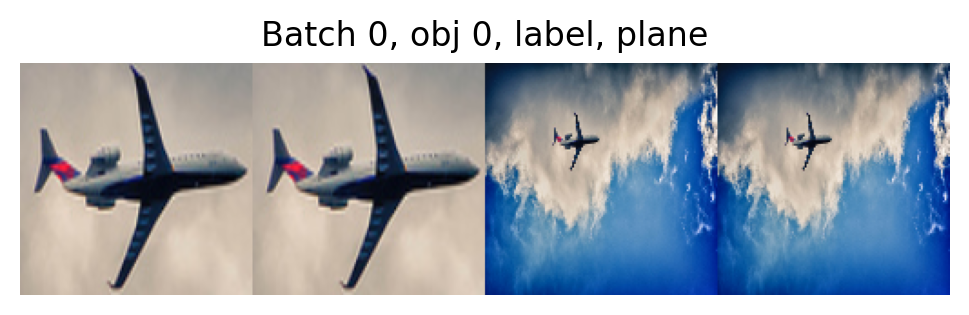

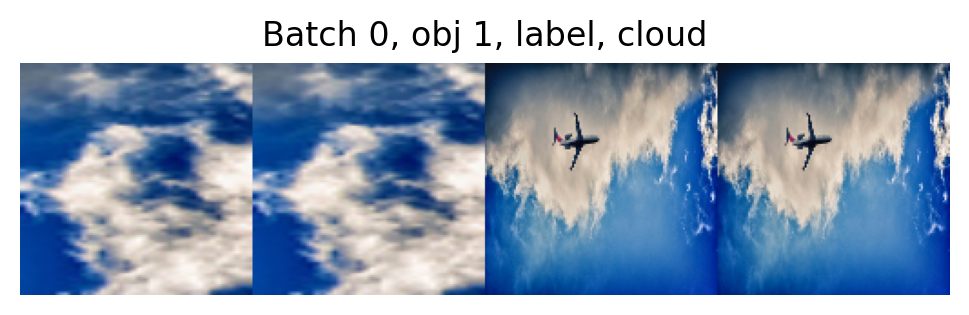

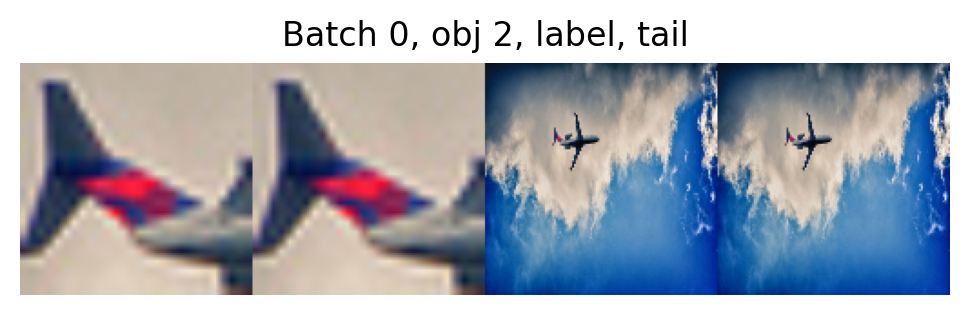

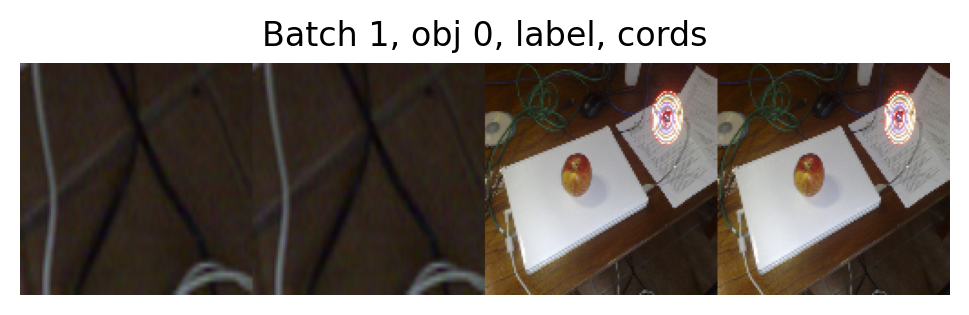

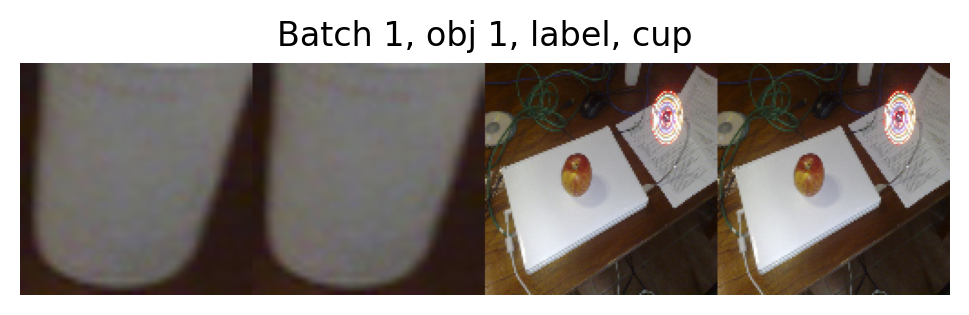

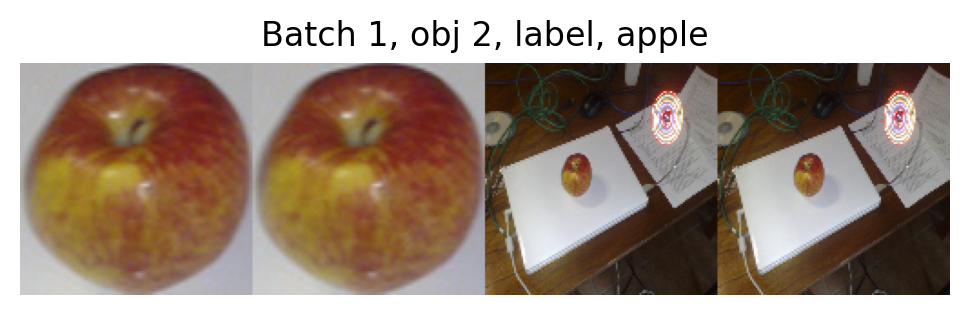

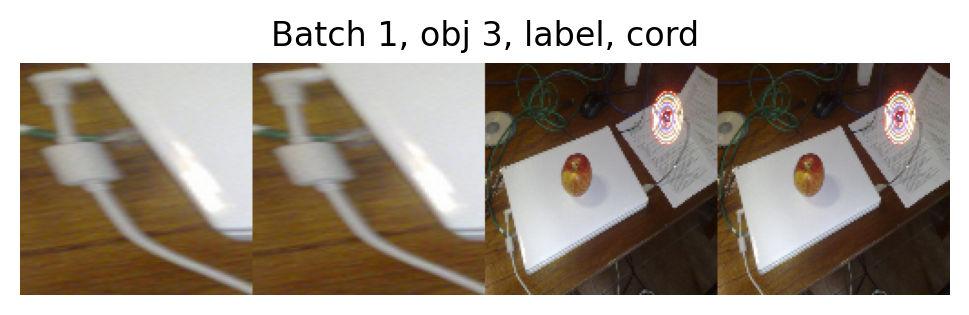

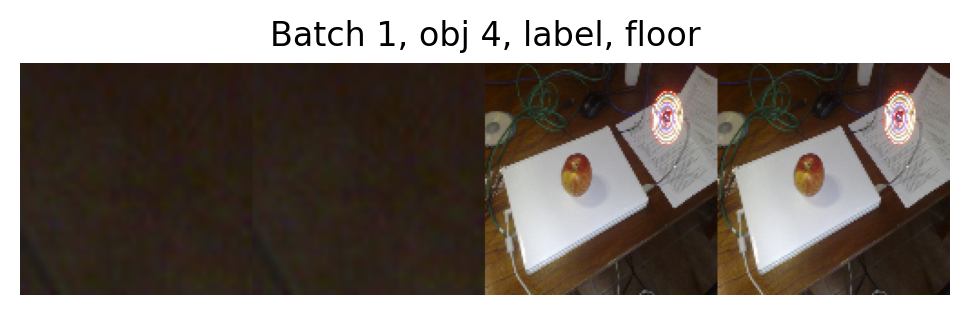

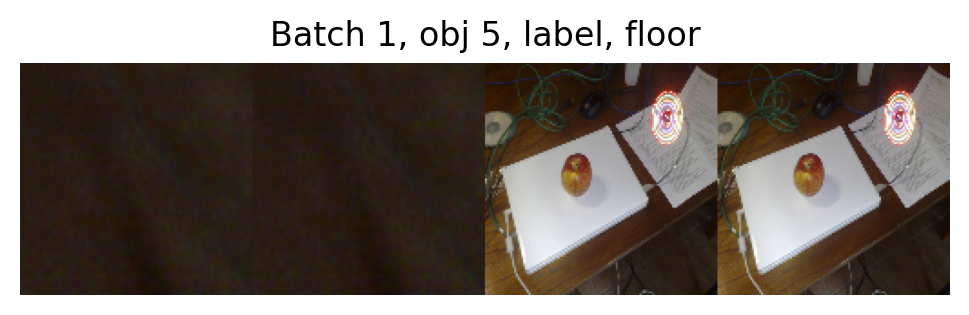

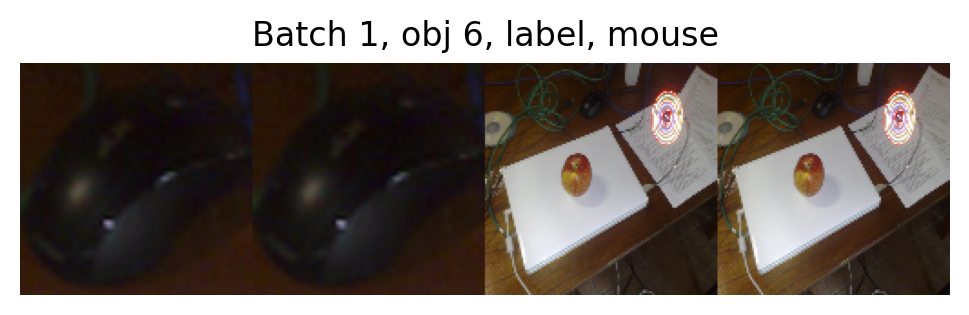

In [4]:
for batch_id, batch in enumerate(dl):
    if batch_id == 2:
        break
    sender_input, labels, recv_input, aux_input = batch
    
    # sender input of size bsz X max_objs X 3 X image_size X image_size
    for idx in range(sender_input.shape[1]):
        if aux_input["mask"][batch_id][idx] == False:
            continue
        obj_sender = sender_input[batch_id][idx].permute(1, 2, 0)
        obj_recv = recv_input[batch_id][idx].permute(1, 2, 0)

        sender_img = aux_input["sender_image"][batch_id].permute(1, 2, 0)
        recv_img = aux_input["recv_image"][batch_id].permute(1, 2, 0)
        lineup = torch.cat([obj_sender, obj_recv, sender_img, recv_img], dim=1)
        
        label_sender = id2class.get(labels[batch_id][idx].item(), "None")
        label_recv = id2class.get(labels[batch_id][idx].item(), "None")

        plt.title(f"Batch {batch_id}, obj {idx}, label, {label_sender}")
        plt.imshow(lineup.numpy())
        plt.axis('off')
        plt.show()